# Modeling housing prices in Ames, Iowa
### Project 02 --
---
---

##  Problem Statement
To predict house sale prices in Ames Iowa from 2007-2010, using only numerically represented data leads to highly inaccurate models and predicted sales values. By approaching different strategies for quantifying different classifications in the dataset, engineering enough features to get a significantly more accurate model, while avoiding excesses that could add costly computation time and risk overfitting models

## The Dataset
A Data Dictionary is provided in the repository for this project in kaggle.md

An example column from the dataset that will be considered for quantification:
* MSZoning: Identifies the general zoning classification of the sale.
    - A Agriculture
    - C Commercial
    - FV Floating Village Residential
    - I Industrial
    - RH Residential High Density
    - RL Residential Low Density
    - RP Residential Low Density Park
    - RM Residential Medium Density

## Assumptions 
- Assuming that using mean values from the training set to encode columns with missing information in the testing set won’t contaminate the test dataset
- Using mean vs. median imputation/-encoding won't have significant impact on the columns those methods were used on 
- Aiming to keep number of features to under approx. 100 to manage computation time and avoid overfit
- Private equity and pension funds won't start buying up so many homes that they become unreachably, unthinkably expensive even in places like Ames, Iowa 


---
### Import and read in
---

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_regression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet
from sklearn.metrics import mean_squared_error

# formatting as per Week 1.07 lesson: Intro to Pandas groupby
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

In [180]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
sample_sub_reg = pd.read_csv('./datasets/sample_sub_reg.csv')
print('Train shape on import', train.shape)

Train shape on import (2051, 81)


---
### Filters 
---
The following filters are used as a cutoff point for columns that don't correlate strongly to Sale Price, and setting a bottom quantile for columns that LassoCV's calculated alpha values

In [181]:
lasso_filter = 0.1
corr_filter = 0.08

---
### Data Cleaning
---

Retaining the Id column for use in Kaggle submissions

In [182]:
train.columns = train.columns.str.replace(" ", "") 
test.columns = test.columns.str.replace(" ", "") 
id_s = test['Id']

In [183]:
# dropping ID and PID 
train = train.drop(columns=['Id', 'PID'])
test = test.drop(columns=['Id', 'PID'])

### Mean Encoding
Several encoding strategies were considered and although little difference was noticed between mean and median encoding, the frequency encoding did lead to some interesting results and are retained here for possible future feature adjustments 

In [184]:
# mean enconding as per https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
def mean_encoder(col):
    mean_encode = train.groupby(col)['SalePrice'].mean()
    train[f"{col}_mean_enc"] = train[col].map(mean_encode)
    test[f"{col}_mean_enc"] = test[col].map(mean_encode)
    pass

In [185]:
def median_encoder(col):
    median_encode = train.groupby(col)['SalePrice'].median()
    train[f"{col}_median_enc"] = train[col].map(median_encode)
    test[f"{col}_median_enc"] = test[col].map(median_encode)
    pass

In [186]:
# frequency enconding as per https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
def freq_encoder(col):
    freq_encode = train.groupby(col).size()/len(train)
    train[f"{col}_freq_enc"] = train[col].map(freq_encode)
    test[f"{col}_freq_enc"] = test[col].map(freq_encode)
    pass

Selection on which columns were either very full of, or at least had a non-negligible number of null values, differentiated so different approaches could be taken for choosing to drop them or not

In [187]:
# train[(train.select_dtypes(object).isnull().sum() < 150).index].isnull().sum()

In [188]:
mostly_null_objects = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
kinda_null_objects = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

train = train.drop(columns=mostly_null_objects)
test = test.drop(columns=mostly_null_objects)
# train = train.drop(columns=kinda_null_objects)
# test = test.drop(columns=kinda_null_objects)

In [189]:
# round(train.groupby('PoolQC')['SalePrice'].agg(['mean', 'median']), 2)

In [190]:
# for i in train.select_dtypes(object):
#     mean_encoder(i)
#     pass

In [191]:
# mean_encoder('GarageType_mean_enc')
# mean_encoder('GarageFinish_mean_enc')
# mean_encoder('GarageQual_mean_enc')
# mean_encoder('GarageCond_mean_enc')

--- 
### EDA with original columns 
---
Looking at some of the strongest correlated columns to Sale Price as well as some other columns that intuition would suggest have a stronger relationship, like square footage, zoning classifcations, etc. 

/Users/rylandmatthews/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


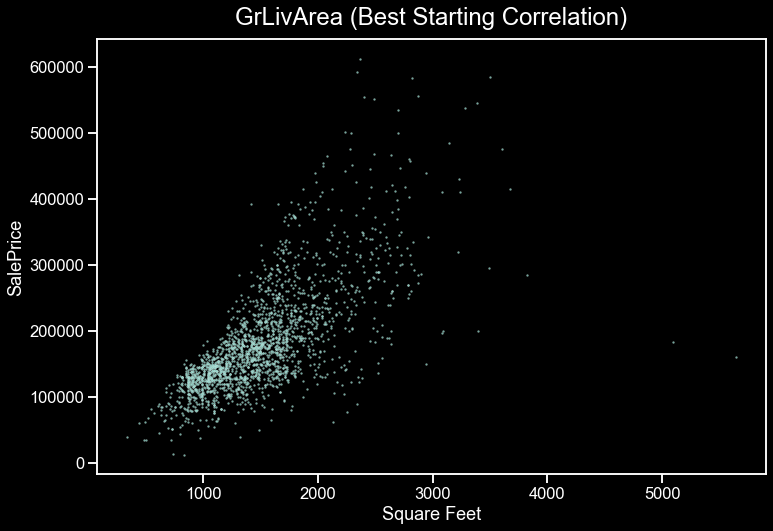

In [192]:
plt.figure(figsize=(12, 8))
sns.scatterplot(train['GrLivArea'], train['SalePrice'], s=4, alpha=0.8);
plt.xlabel('Square Feet')
plt.title('GrLivArea (Best Starting Correlation)', fontsize=24, y=1.02);

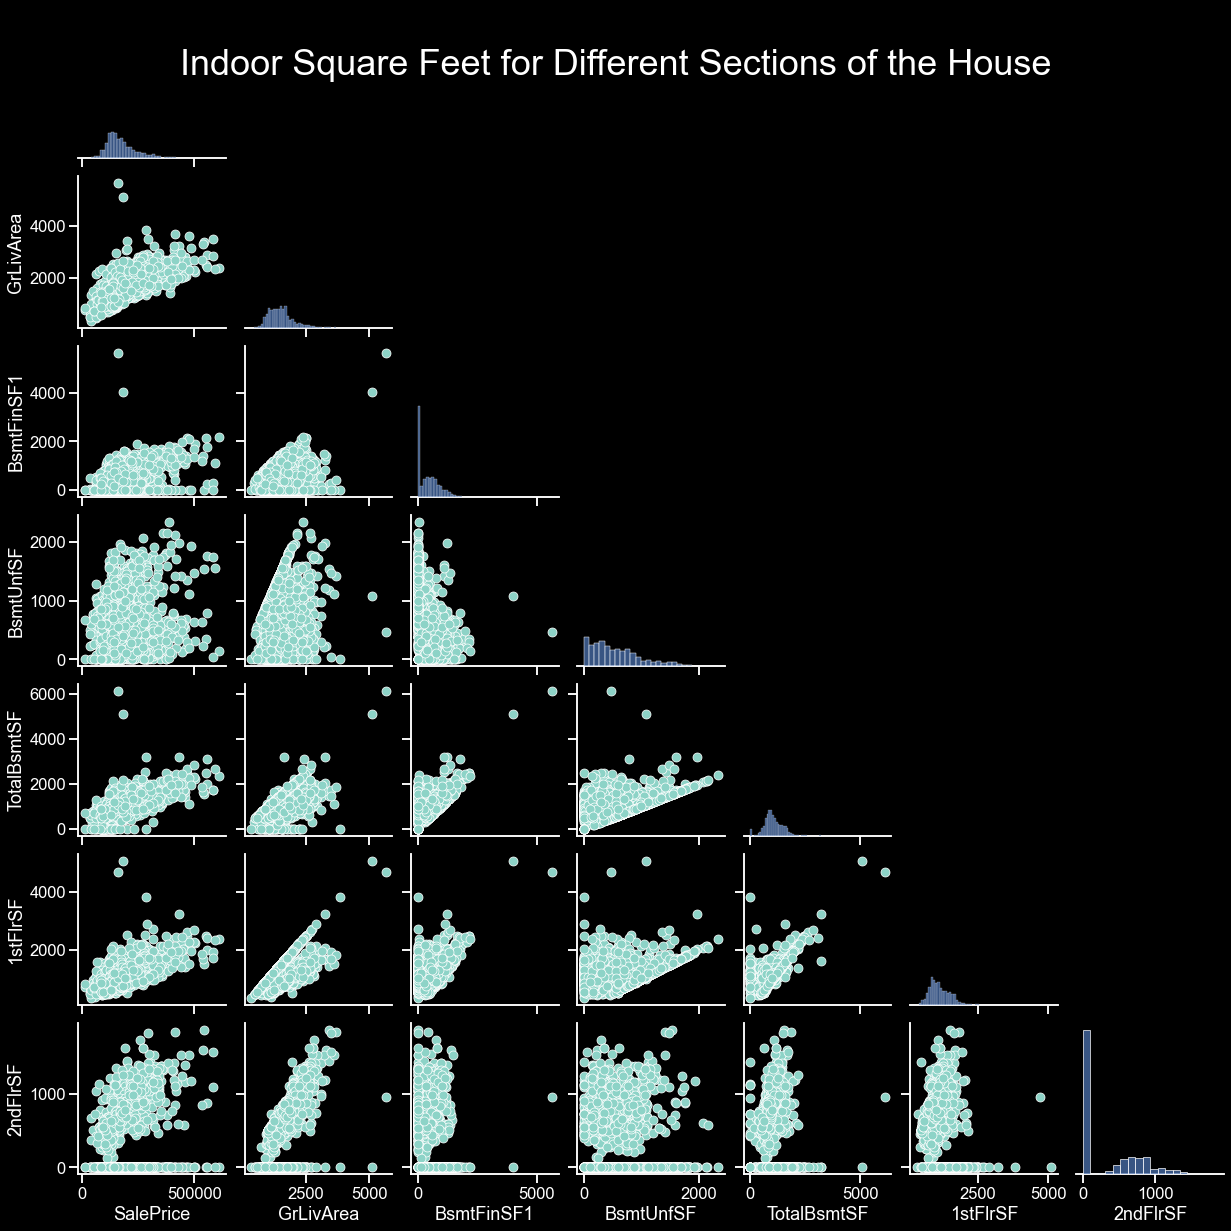

In [193]:
cols = ['SalePrice', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',]
# plt.figure(figsize=(12,12))
sns.pairplot(train[cols], corner=True)
# added pair plot title as per https://stackoverflow.com/questions/36813396/how-to-show-the-title-for-the-diagram-of-seaborn-pairplot-or-pridgrid
plt.suptitle('Indoor Square Feet for Different Sections of the House', fontsize=36, y=.95);

In [194]:
# building classes
train.MSSubClass.value_counts()

20     770
60     394
50     198
120    132
30     101
70      90
160     88
80      86
90      75
190     46
85      28
75      16
180     11
45      11
40       4
150      1
Name: MSSubClass, dtype: int64

In [195]:
# Zoning classes 
train.MSZoning.value_counts()

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MSZoning, dtype: int64

In [196]:
round(train.groupby('MSSubClass')['SalePrice'].agg(['mean', 'median']), 2)

,mean,median
MSSubClass,,
20,189305.49,160000
30,94936.35,99500
40,119125.00,122500
45,116372.73,113000
50,137270.00,129675
60,239225.77,215100
70,153354.46,147500
75,204875.00,163500
80,169569.83,165000


In [197]:
round(train.groupby('LandSlope')['SalePrice'].agg(['mean', 'median']), 2)

,mean,median
LandSlope,,
Gtl,180358.48,161000
Mod,204639.47,188250
Sev,194598.00,200750


In [198]:
# was the sale made post-recession?
round(train.groupby('YrSold')['SalePrice'].agg(['mean', 'median', 'std']), 2)
# as per Week 4.04 lesson: Classification Metrics II 
# train['PostRecession'] = np.where(train['YrSold'] == 2010, 1, 0)

,mean,median,std
YrSold,,,
2006,179471.61,159250,81906.25
2007,185524.51,167150,77140.41
2008,181750.37,163000,77388.34
2009,182455.24,163000,81882.46
2010,174180.06,155000,77047.78


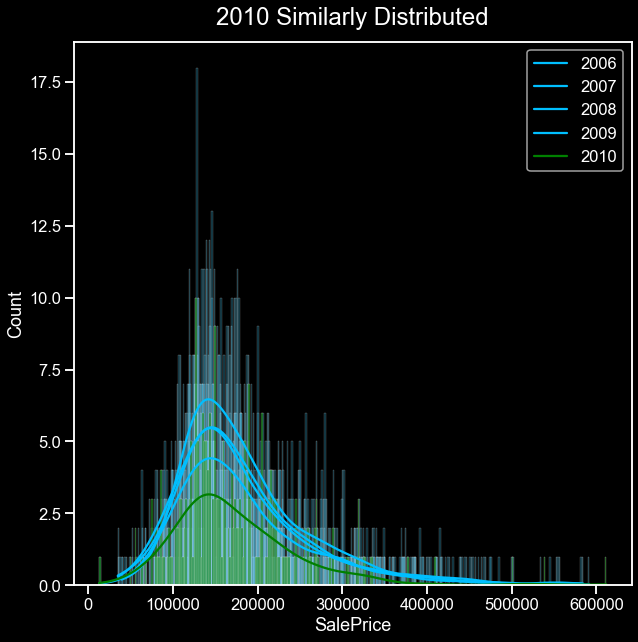

In [199]:
plt.figure(figsize=(10, 10))
sns.histplot(train[train['YrSold'] == 2006]['SalePrice'], bins=300, alpha=0.2, kde=True, color='deepskyblue')
sns.histplot(train[train['YrSold'] == 2007]['SalePrice'], bins=300, alpha=0.2, kde=True, color='deepskyblue')
sns.histplot(train[train['YrSold'] == 2008]['SalePrice'], bins=300, alpha=0.2, kde=True, color='deepskyblue')
sns.histplot(train[train['YrSold'] == 2009]['SalePrice'], bins=300, alpha=0.2, kde=True, color='deepskyblue')
sns.histplot(train[train['YrSold'] == 2010]['SalePrice'], bins=300, alpha=0.6, kde=True, color='Green')
plt.title('2010 Similarly Distributed', fontsize = 24, y=1.02)
plt.legend(['2006', '2007', '2008', '2009', '2010']);

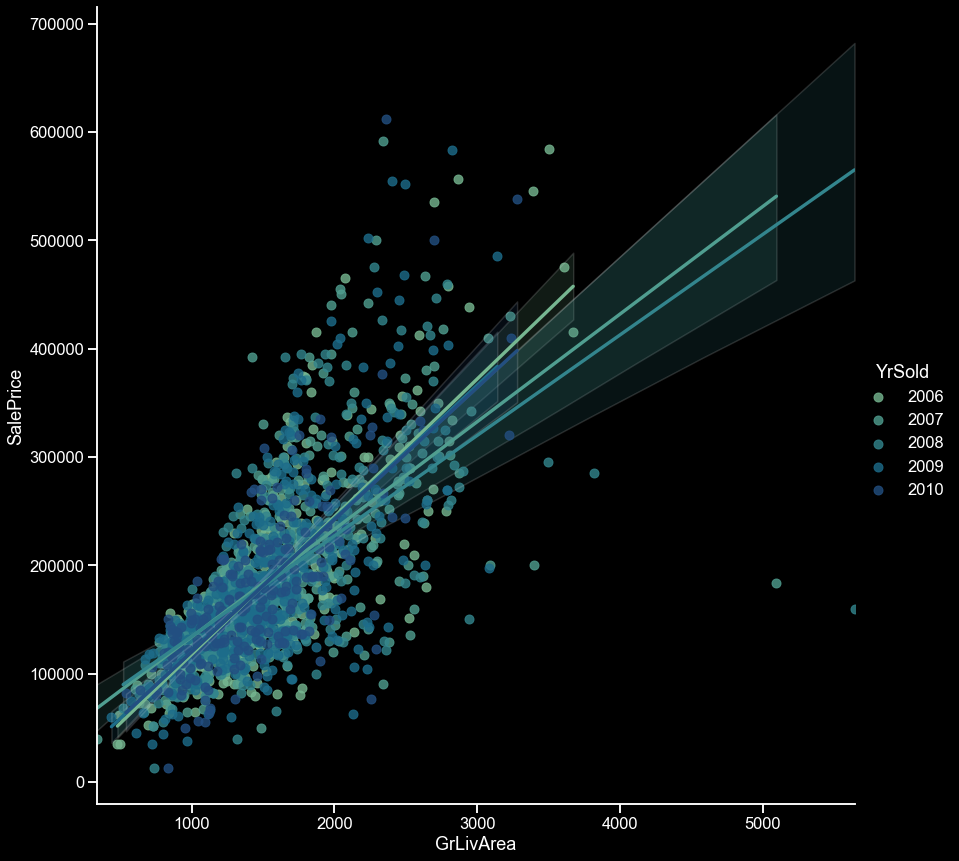

In [200]:
sns.lmplot(data=train, x='GrLivArea', y='SalePrice', 
           hue='YrSold', height=12, palette='crest');

Considering if the Year Sold would have a strong impact on Sale Price because of the '08-'09 Recession. This ended up being a much less significant factor, often getting cut before going into the models or being significantly reduced by the models

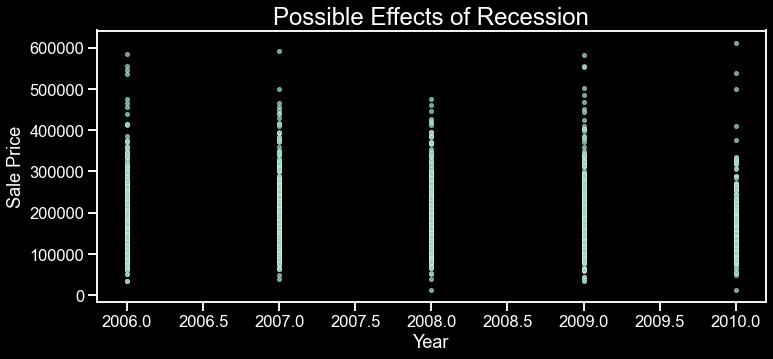

In [201]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=train['YrSold'], y=train['SalePrice'], s=20, alpha=0.8)
plt.ylabel('Sale Price')
plt.xlabel('Year')
plt.title('Possible Effects of Recession', fontsize=24);

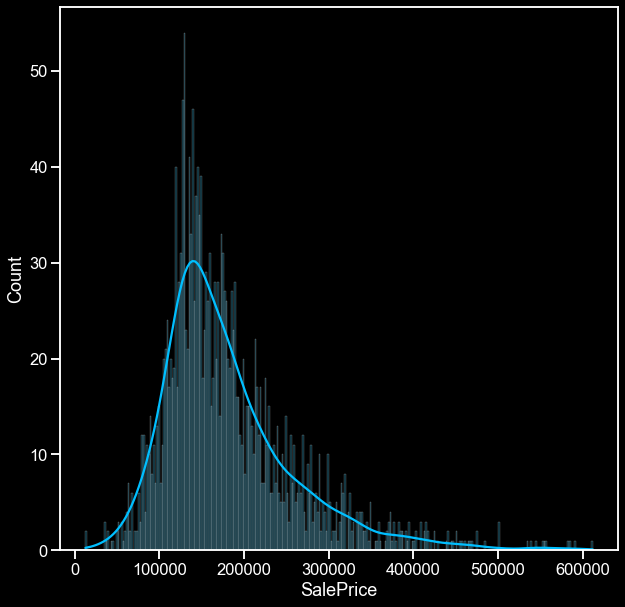

In [202]:
plt.figure(figsize=(10, 10))
sns.histplot(train['SalePrice'], bins=300, alpha=0.2, kde=True, color='deepskyblue');

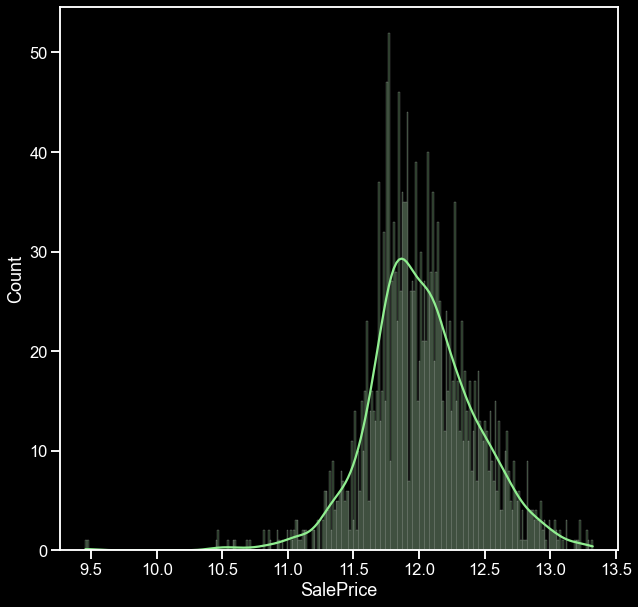

In [203]:
plt.figure(figsize=(10, 10))
sns.histplot(train['SalePrice'].map(np.log), bins=300, alpha=0.2, kde=True, color='lightgreen');

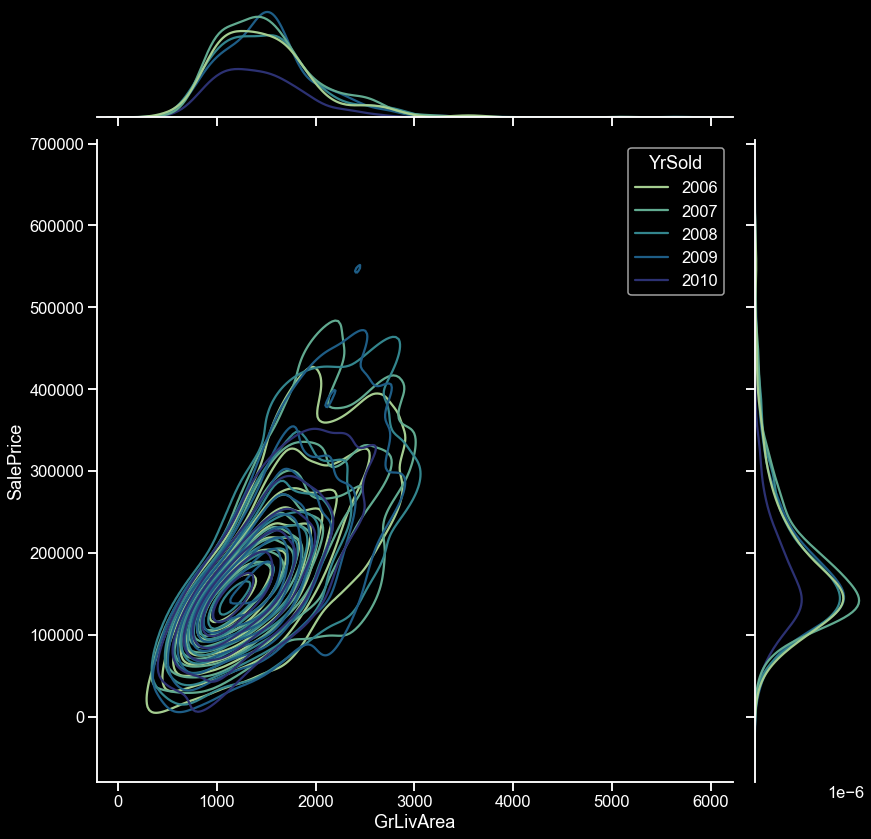

In [204]:
sns.jointplot(data=train, x='GrLivArea', y='SalePrice', hue='YrSold',
              kind='kde', height=12, palette='crest');

/Users/rylandmatthews/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


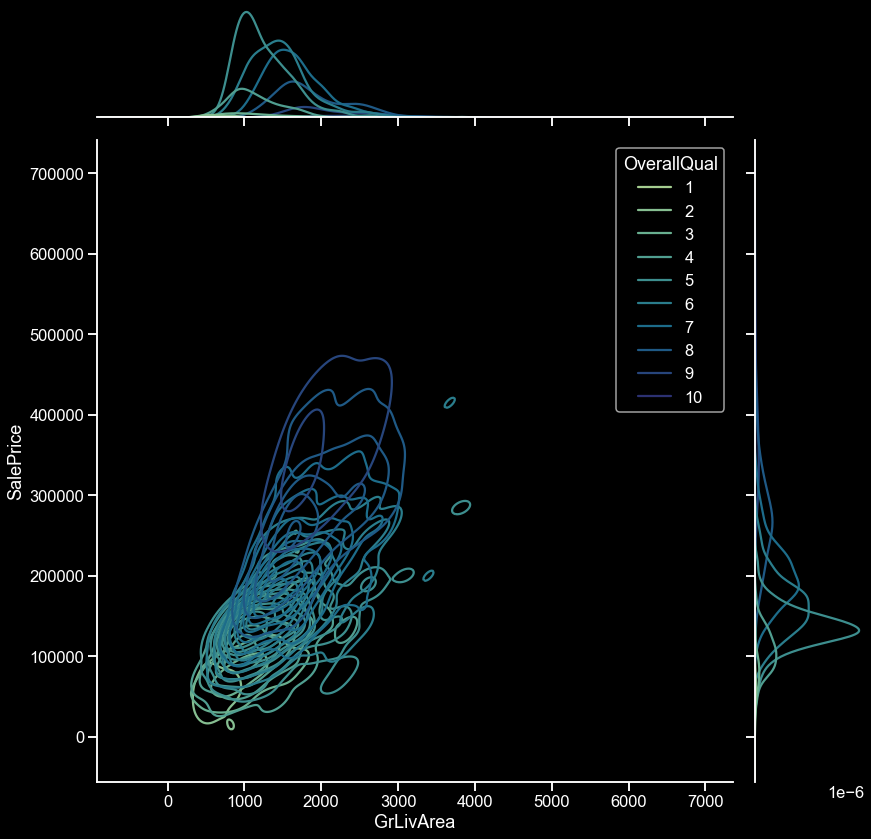

In [211]:
sns.jointplot(data=train, x='GrLivArea', y='SalePrice', hue='OverallQual',
              kind='kde', height=12, palette='crest');

Text(0.5, 1.02, 'Correlation to SalePrice Before Feature Engineering (Top 25)')

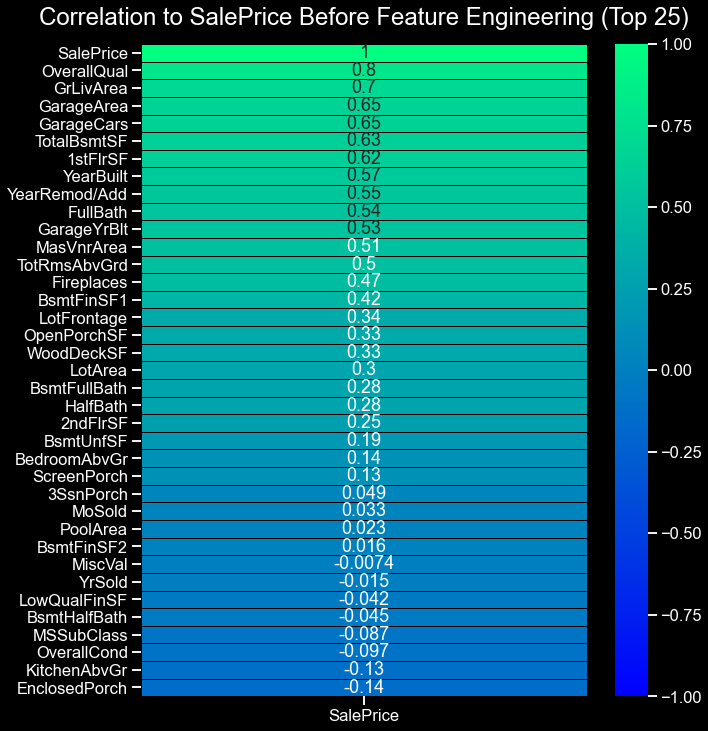

In [205]:
plt.figure(figsize=(10,12))
sns.heatmap(train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), cmap='winter', vmin=-1, vmax=1, annot=True, linecolor='black', linewidths=1);
plt.title('Correlation to SalePrice Before Feature Engineering (Top 25)', fontsize=24, y=1.02)

--- 
### Feature Engineering
---

Using the mean_encoder function to quantify many of the classification columns 

In [206]:
for i in train.select_dtypes(object):
    mean_encoder(i)
#     freq_encoder(i)

Lot Frontage and Garage Year Built are numeric columns that were good candidates for mean imputation. Median imputation was considered but the difference was negligible 

In [32]:
# Compared median and mode of LotFrontage and GarageYrBlt and chose to impute the mean 
# Imputing mean as per Week 03 Breakfast Hour: Missing Data  
for i in ['LotFrontage', 'GarageYrBlt']:
    train[i].fillna(train[i].mean(), inplace=True)
    test[i].fillna(train[i].mean(), inplace=True)

In [33]:
print('Train shape before dropping remaining null rows:', train.shape)
before = train.shape[0]
train = train.dropna()
print('Train shape after dropping remaining null rows:', train.shape)
print('Number of rows dropped:', before - train.shape[0], ', or ', round(100 * (before - train.shape[0])/before, 2), "%" )

Train shape before dropping remaining null rows: (2051, 111)
Train shape after dropping remaining null rows: (1866, 111)
Number of rows dropped: 185 , or  9.02 %


Creating columns that consider different possible relationships between subcategories of Indoor and Outdoor square footage 

In [34]:
indoor_square_footage = ['GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',]

In [35]:
# Create column for total indoor square footage
train['TotalIndoorSF'] = train[indoor_square_footage].sum(axis=1)
test['TotalIndoorSF'] = test[indoor_square_footage].sum(axis=1)

In [36]:
# Create column for the product of indoor square footage
train['ProductIndoorSF'] = train[indoor_square_footage].product(axis=1)
test['ProductIndoorSF'] = test[indoor_square_footage].product(axis=1)

In [37]:
# Create column for square of total indoor square footage 
train['TotalIndoorSF_squared'] = train['TotalIndoorSF'] ** 2
test['TotalIndoorSF_squared'] = test['TotalIndoorSF'] ** 2

In [38]:
train['TotalIndoorSF_sqrt'] = train['TotalIndoorSF'] ** 0.5
test['TotalIndoorSF_sqrt'] = test['TotalIndoorSF'] ** 0.5

In [39]:
# Create column for outdoor square footage 
outdoor_sq_footage = ['WoodDeckSF', 'OpenPorchSF','EnclosedPorch', 'ScreenPorch']
train['TotalOutdoorSF'] = train[outdoor_sq_footage].sum(axis=1)
test['TotalOutdoorSF'] = test[outdoor_sq_footage].sum(axis=1)

In [40]:
# looking at Garage Area x Garage Cars since they're both high correlation 
# train['GarageCars_x_Area'] = train['GarageCars'] * train['GarageArea']
# test['GarageCars_x_Area'] = test['GarageCars'] * test['GarageArea']

In [41]:
# Create column for relationship between the year the house was built and year remodelled 
train['RenoYr_x_YrBuilt'] = train['YearRemod/Add'] * train['YearBuilt']
test['RenoYr_x_YrBuilt'] = test['YearRemod/Add'] * test['YearBuilt']

In [42]:
# Create column for relationship between overall quality vs. condition 
train['OverallQual_x_Cond'] = train['OverallQual'] * train['OverallCond']
test['OverallQual_x_Cond'] = test['OverallQual'] * test['OverallCond']

In [43]:
# Create column for relationship between overall quality and square footage
train['OverallQual_x_IndoorSF'] = train['OverallQual'] * train['TotalIndoorSF']
test['OverallQual_x_IndoorSF'] = test['OverallQual'] * test['TotalIndoorSF']

In [44]:
# Create column squaring the encoded overall quality 
train['OverallQual_squared'] = train['OverallQual'] ** 2
test['OverallQual_squared'] = test['OverallQual'] ** 2

Since Neighborhood once mean-encoded was one of the highest correlations to Sale Price, it was also one-hot-encoded to make it even more prominently featured in the models 

In [45]:
# One Hot encoding for highest correlation object columns 
to_one_hot = ['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual']
for i in to_one_hot:
    train = pd.get_dummies(train, prefix=[i], columns=[i])
    test = pd.get_dummies(test, prefix=[i], columns=[i])

In [46]:
# As per DSI 426 Office Hours on May 17, 2021
corr_cutoff = corr_filter # from filter dashboard at top of notebook 
mask = abs(train.corr()['SalePrice']) 
# print(mask[mask > corr_cutoff].index)
train = train[mask[mask >= corr_cutoff].index]
test = test[train.drop(columns='SalePrice').columns]

The final step is keeping only numeric type columns, done last so that object columns could have more than one feature engineering process done to them before being dropped 

In [47]:
# keeping only numeric things 
train = train.select_dtypes(np.number)
test = test.select_dtypes(np.number)
print('Train shape after feature engineering', train.shape)

Train shape after feature engineering (1866, 95)


---
### EDA with new columns 
---

Many of our highest correlation features to Sale Price were created in Feature Engineering

Text(0.5, 1.02, 'Correlation to SalePrice After Feature Engineering (Top 25)')

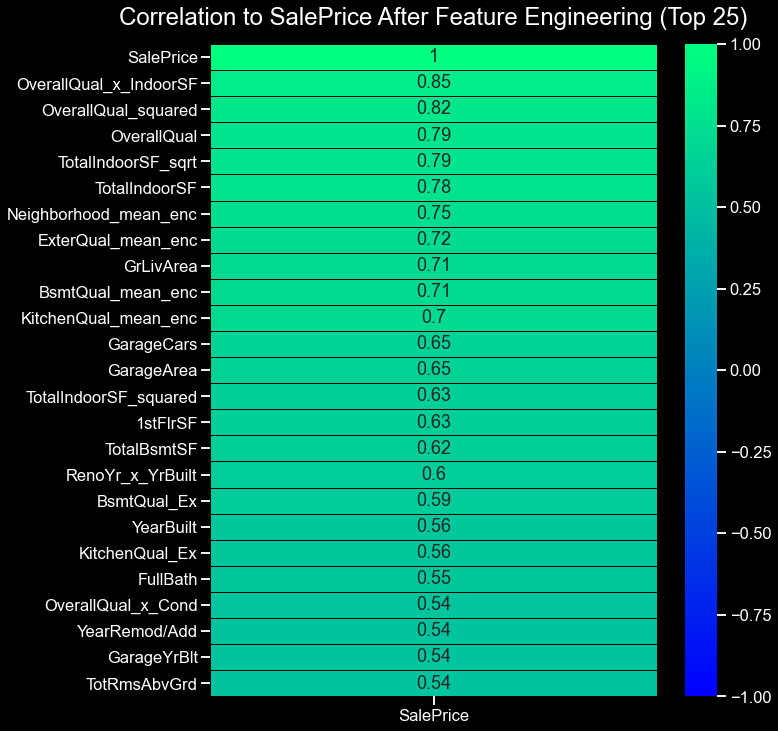

In [48]:
# Heatmap 
plt.figure(figsize=(10,12))
sns.heatmap(train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)[:25], cmap='winter', vmin=-1, vmax=1, annot=True, linecolor='black', linewidths=1);
plt.title('Correlation to SalePrice After Feature Engineering (Top 25)', fontsize=24, y=1.02)

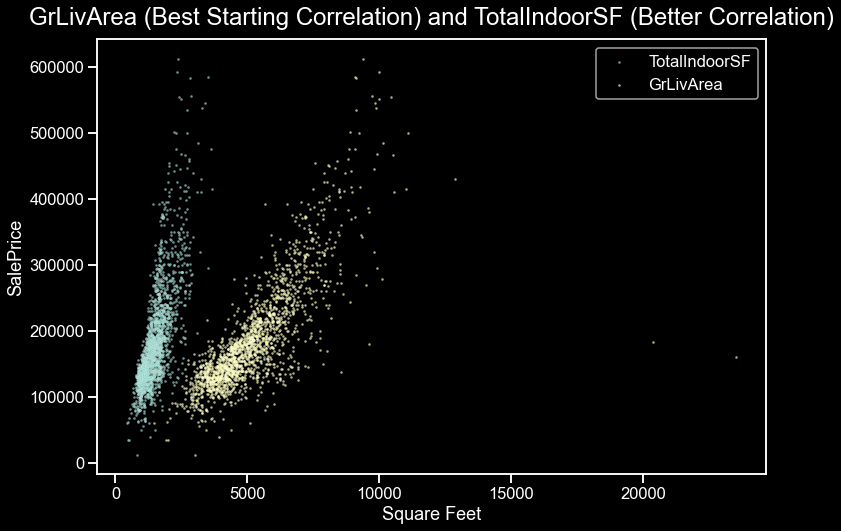

In [78]:
plt.figure(figsize=(12, 8))
sns.color_palette("crest", as_cmap=True)
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'], s=5, alpha=0.7, cmap='crest')
sns.scatterplot(x=train['TotalIndoorSF'], y=train['SalePrice'], s=5, alpha=0.7, cmap='crest')
plt.xlabel('Square Feet')
plt.title('GrLivArea (Best Starting Correlation) and TotalIndoorSF (Better Correlation)', fontsize=24, y=1.02)
plt.legend(['TotalIndoorSF', 'GrLivArea']);

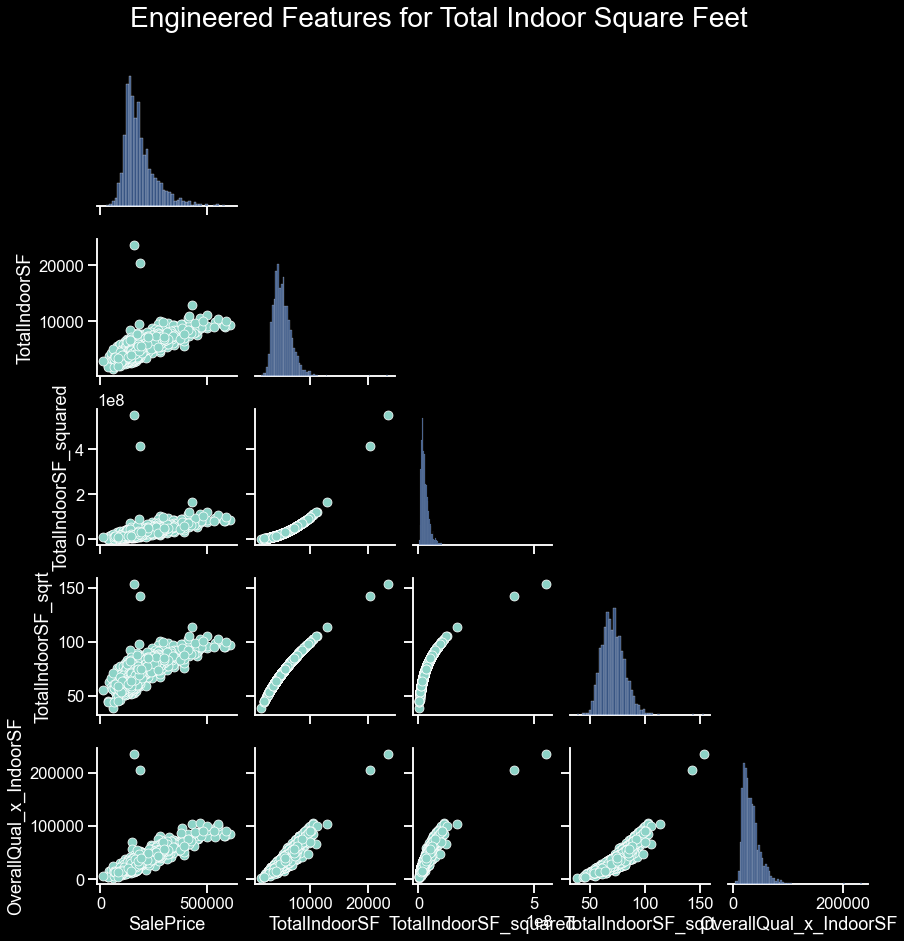

In [50]:
cols = ['SalePrice', 'TotalIndoorSF', 'TotalIndoorSF_squared', 'TotalIndoorSF_sqrt', 'OverallQual_x_IndoorSF']
sns.pairplot(train[cols], corner=True)
plt.suptitle('Engineered Features for Total Indoor Square Feet', fontsize=28, y=1.05);

In [51]:
# plt.figure(figsize=(18,18))
# sns.heatmap(train.corr(), cmap='winter', vmin=-1, vmax=1, annot=False, linecolor='black', linewidths=1);

Final Step before export is to impute the missing values for the kaggle holdout test file
Median and KNN imputation was tried as well but the model performed best usign the mean values 

In [52]:
# Mean-imputing kaggle test set
for i in test:
    mean = test[i].mean()
    test[i].fillna(mean, inplace=True)

---
### Export
---
Checking the shape of the train and test dataframes before exporting them 
Train should have one more column than Test 

In [53]:
print('Test shape:', test.shape)
print('Train shape:', train.shape)
train.to_csv('./datasets/cleaned_train.csv')
test.to_csv('./datasets/cleaned_test.csv')
id_s.to_csv('./datasets/id_s.csv')

Test shape: (878, 94)
Train shape: (1866, 95)


---
---
---

--- 
### Read back in
---

In [54]:
cleaned_train_path = './datasets/cleaned_train.csv'
cleaned_test_path = './datasets/cleaned_test.csv'
id_s_path = './datasets/id_s.csv'
df_train = pd.read_csv(cleaned_train_path)
df_test = pd.read_csv(cleaned_test_path)
id_s = pd.read_csv(id_s_path)

In [55]:
df_train.drop(columns='Unnamed: 0', inplace=True)
df_test.drop(columns='Unnamed: 0', inplace=True)
id_s.drop(columns='Unnamed: 0', inplace=True)

In [56]:
# Set a random seed
np.random.seed(42)

--- 
### Create X & y
---

In [57]:
# X & y for test-train split of the train.csv set
X = df_train.drop('SalePrice', axis=1).copy()
y = np.log(df_train['SalePrice'].copy())

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape, "y_test shape:", y_test.shape)

X_train shape: (1119, 94) X_test shape: (747, 94)
y_train shape: (1119,) y_test shape: (747,)


In [59]:
# Calculate mean SalePrice
mean_sale_price = df_train['SalePrice'].mean()
mean_sale_price

187003.3869239014

# Pipeline(s)

In [60]:
# from https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

/Users/rylandmatthews/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


---
### Lasso Regularization
---

In [61]:
# Ignore warnings as per https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
@ignore_warnings(category=ConvergenceWarning)

def lasso(X_train, X_test, y_train, y_test):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    lasso_alphas = np.logspace(-2, 2, 20),
    lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, max_iter=5000)
    lasso_cv.fit(X_train, y_train)
    
    print("LASSO")
    preds = lasso_cv.predict(X_test)
    print("Best Lasso Train Score:", lasso_cv.score(X_train, y_train))
    print("Best Lasso Test Score:", lasso_cv.score(X_test, y_test))
    rmse = mean_squared_error(y_test, preds, squared=False)
    print("RMSE for split:", rmse)
    print("RMSE as % of mean SalePrice:", round(100 * rmse / mean_sale_price, 2), "%")
    return lasso_cv.coef_, preds, rmse 

Before dropping any values, LassoCV regularly returns the closest bias/variance balance and the best RMSE value of the three models 

In [62]:
lasso_coefs, lasso_preds, lasso_rmse = lasso(X_train, X_test, y_train, y_test)
lasso_coef_df = pd.DataFrame(lasso_coefs, index=X_test.columns, columns=['coefs']).sort_values(by='coefs', ascending=False)

LASSO
Best Lasso Train Score: 0.0
Best Lasso Test Score: -0.0026768619842347796
RMSE for split: 0.39618268066576284
RMSE as % of mean SalePrice: 0.0 %


In [63]:
# lasso_filter from filter dashboard at top of notebook 
approaching_zero = abs(lasso_coef_df['coefs']).quantile(q=lasso_filter)
approaching_zero

0.0

In [64]:
drop_from_lasso = lasso_coef_df[abs(lasso_coef_df['coefs']) < approaching_zero].index
drop_from_lasso

Index([], dtype='object')

{This cell below currently requires copy&pasting the output from drop_from_lasso into the lasso_returns variable, but I'm hoping to streamline that in the near future}

In [65]:
# dropping from LassoCV
lasso_returns = ['CentralAir_mean_enc', 'GarageCond_mean_enc', 'GarageFinish_mean_enc',
       'KitchenQual_TA', 'Neighborhood_Veenker', 'Neighborhood_SWISU',
       'MasVnrArea', 'GarageType_mean_enc', 'FullBath', 'Electrical_mean_enc']
X_train = X_train.drop(columns=lasso_returns)
X_test = X_test.drop(columns=lasso_returns)

Running through lasso again after dropping set percentile of columns based on returned coefficients 

In [66]:
lasso_coefs, lasso_preds, lasso_rmse = lasso(X_train, X_test, y_train, y_test)

LASSO
Best Lasso Train Score: 0.0
Best Lasso Test Score: -0.0026768619842347796
RMSE for split: 0.39618268066576284
RMSE as % of mean SalePrice: 0.0 %


In [67]:
approaching_zero = abs(lasso_coef_df['coefs']).quantile(q=lasso_filter)
approaching_zero

0.0

The LassoCV model does start to scatter the residuals some, compared to the same model without the feature engineering steps. 

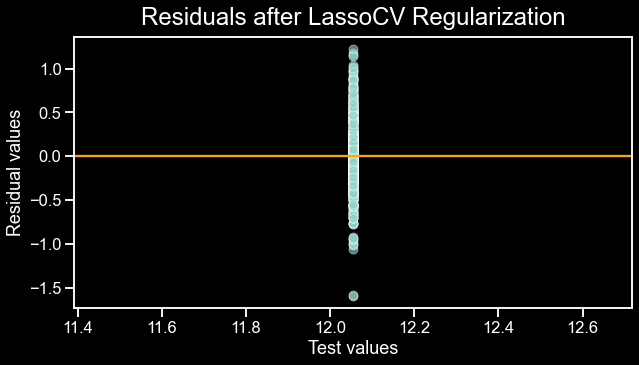

In [68]:
lasso_residuals = y_test - lasso_preds
plt.figure(figsize=(10,5))
sns.scatterplot(x=lasso_preds, y=lasso_residuals, alpha=0.6)
plt.axhline(0, color='orange')
plt.xlabel('Test values')
plt.ylabel('Residual values')
plt.title('Residuals after LassoCV Regularization', fontsize = 24, y=1.02);

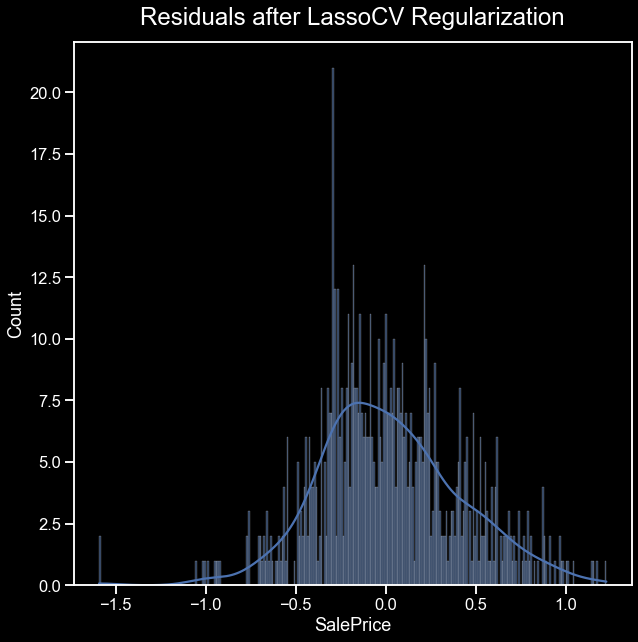

In [69]:
plt.figure(figsize=(10, 10))
sns.histplot(lasso_residuals, bins=300, kde=True)
plt.title('Residuals after LassoCV Regularization', fontsize = 24, y=1.02);

---
### GridSearch
---

In [74]:
# from https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
# @ignore_warnings(category=ConvergenceWarning)

def pipe(X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('mmsc', MinMaxScaler()),
#         ('sc', StandardScaler()),
        ('enet', ElasticNet())
    ])
    
    gridsearch_params = {
#         'sc__with_mean': [False],
#         'sc__with_std': [False],
        'enet__alpha': np.logspace(-2, 2, 40),
        'enet__l1_ratio': np.linspace(0, 1, 50),
#         'enet__fit_intercept': [True, False],
        'enet__max_iter': [2500, 50000]
    }

    pipeline_gridsearch = GridSearchCV(
        estimator=pipeline,
        param_grid=gridsearch_params,
        cv=5,
        verbose=1, 
        n_jobs=-1
    )
    
    pipeline_gridsearch.fit(X_train, y_train)
    print("ELASTICNET")
    print("Best Score:", pipeline_gridsearch.best_score_)
    print("Best Estimator:", pipeline_gridsearch.best_estimator_)
    preds = pipeline_gridsearch.predict(X_test)
    print("Mean Test Prediction:", preds.mean())
    print("Train Score:", pipeline_gridsearch.score(X_train, y_train))
    print("Test Score:", pipeline_gridsearch.score(X_test, y_test))
    rmse = mean_squared_error(y_test, preds, squared=False)
    print("RMSE for split:", rmse)
    print("RMSE as % of mean SalePrice:", round(100 * rmse / mean_sale_price, 2), "%")
    return preds, rmse

In [71]:
# pipeline = Pipeline([
#         ('sc', StandardScaler()),
#         ('enet', ElasticNet())
#     ])
# pipeline.get_params()

In [75]:
gridsearch_preds, gridsearch_rmse = pipe(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 20000 candidates, totalling 100000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1842 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 2384 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 4492 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 6568 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 8728 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 12136 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 15056 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 19932 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 28320 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 37336 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 50184 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 66872 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 83770 tas

ELASTICNET
Best Score: 0.8587661499908117
Best Estimator: Pipeline(steps=[('mmsc', MinMaxScaler()),
                ('enet', ElasticNet(alpha=0.01, l1_ratio=0.0, max_iter=2500))])
Mean Test Prediction: 12.078971747500692
Train Score: 0.8855132370345394
Test Score: 0.8798955867592566
RMSE for split: 0.13711800080030417
RMSE as % of mean SalePrice: 0.0 %


/Users/rylandmatthews/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.482293382912664, tolerance: 0.016015449687262248
  model = cd_fast.enet_coordinate_descent(


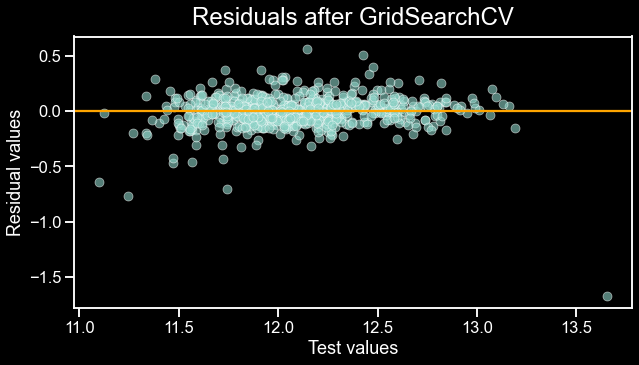

In [126]:
gs_residuals = y_test - gridsearch_preds
plt.figure(figsize=(10,5))
sns.scatterplot(x=gridsearch_preds, y=gs_residuals, alpha=0.6)
plt.axhline(0, color='orange')
plt.xlabel('Test values')
plt.ylabel('Residual values')
plt.title('Residuals after GridSearchCV', fontsize = 24, y=1.02);

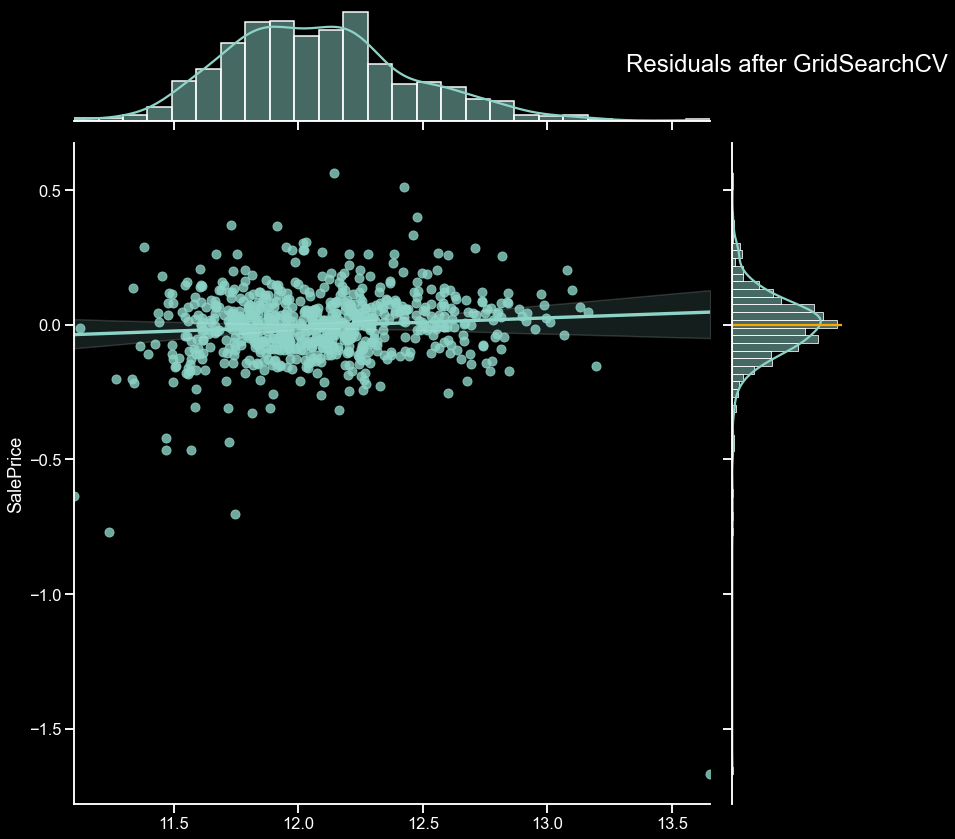

In [147]:
sns.jointplot(x=gridsearch_preds, y=gs_residuals, kind='reg', height=12, palette='crest')
plt.axhline(0, color='orange')
plt.xlabel('Test values')
plt.ylabel('Residual values')
plt.title('Residuals after GridSearchCV', fontsize = 24, y=1.1);

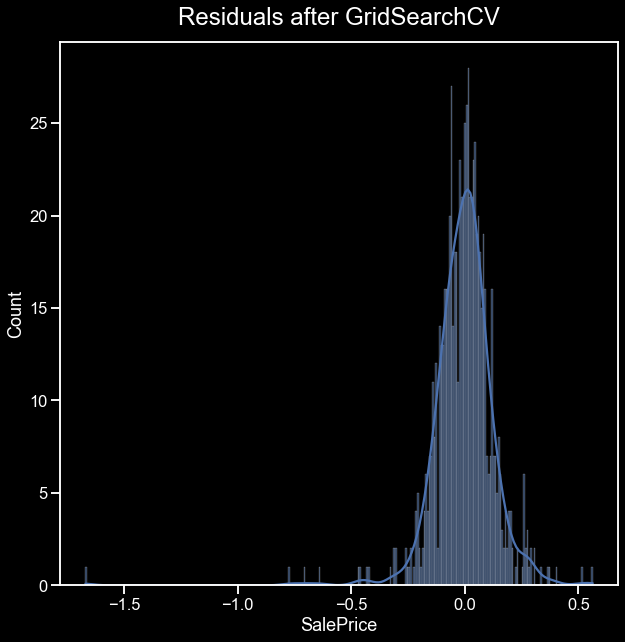

In [127]:
plt.figure(figsize=(10, 10))
sns.histplot(gs_residuals, bins=300, kde=True)
plt.title('Residuals after GridSearchCV', fontsize = 24, y=1.02);

---
### Linear Regression
---

In [ ]:
def linreg(X_train, X_test, y_train, y_test):
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)
    
    lr = LinearRegression()
    lr.fit(X_train_sc, y_train)
    
    print("lr Train R2:", lr.score(X_train_sc, y_train))
    print("lr cross-val score:", cross_val_score(lr, X_train_sc, y_train, cv=3))
    print("lr Test R2:", lr.score(X_test_sc, y_test))
    preds = lr.predict(X_test_sc)
    rmse = mean_squared_error(y_test, preds, squared=False)
    print("lr RMSE:", rmse)
    print("RMSE as % of mean SalePrice:", round(100 * rmse / mean_sale_price, 2), "%")
    return preds, rmse

In [ ]:
lr_preds, lr_rmse = linreg(X_train, X_test, y_train, y_test)

In [ ]:
lr_residuals = y_test - lr_preds
plt.figure(figsize=(10,5))
sns.scatterplot(x=lr_preds, y=lr_residuals, alpha=0.6)
plt.axhline(0, color='orange')
plt.xlabel('Test values')
plt.ylabel('Residual values')
plt.title('Residuals from Linear Regression', fontsize = 24, y=1.02);

In [ ]:
plt.figure(figsize=(10, 10))
# plt.hist(lr_residuals, bins=100);
sns.histplot(lr_residuals, bins=100, kde=True)
plt.title('Residuals from Linear Regression', fontsize = 24, y=1.02);

# Conclusions
Using different imputation and encoding strategies to quantify categorical data significantly improved the quality of the models for this dataset, making a difference of 5-8% in the calculated error for the model, or approx. \$15,000. Please refer to Project-02_slides_rylandmatthews.pdf for a comparison between the more accurate models here, and the same model pipeline with very meager feature engineering. In most instances LassoCV and Linear Regression seemed to model better bias/variance balance and return higher quality predictions 